<img src="https://cdn.siberian.dev/siberian.png" alt="Siberian Logo">

# Text Classification using CNN

This Code Template is for Text Classification using Convolutional Neural Networks (CNN or ConvNet). A Convolutional Neural Network (ConvNet/CNN) is a Deep Learning algorithm that can take in an input, assign importance (learnable weights and biases) to various aspects/objects in the image, and be able to differentiate one from the other.

### Required Packages

In [ ]:
!pip install nltk
!pip install imblearn

In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd 
import seaborn as sns
import re, string
import nltk
import tensorflow as tf
from keras import callbacks
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import RMSprop
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import SnowballStemmer, WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,Dense, Activation, MaxPool1D,Conv1D,Flatten,GlobalAveragePooling1D,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import plot_confusion_matrix,classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


### Initialization

Filepath of CSV file

In [3]:
#filepath
file_path= ""

**Target** variable for prediction.

In [4]:
target=''

Text column containing all the text data


In [5]:
text=''

## Data Fetching

Pandas is an open-source, BSD-licensed library providing high-performance, easy-to-use data manipulation and data analysis tools.

We will use panda's library to read the CSV file using its storage path.And we use the head function to display the initial row or entry.

In [6]:
df=pd.read_csv(file_path)
df.head()

,Unnamed: 0,Label,EmailText
0,0,ham,"Go until jurong point, crazy.. Available only ..."
1,1,ham,Ok lar... Joking wif u oni...
2,2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,3,ham,U dun say so early hor... U c already then say...
4,4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Data Preprocessing

The text data might contain noise in various forms like emotions, punctuation, text in a different case etc. We apply various text preprocessing methods such as converting text to lowercase, remove text in square brackets, remove links, remove special characters and remove words containing numbers to clean the text data and make it ready to feed data to the model.

We also apply lemmetization technique to the data which groups together the different canonical forms of a word so they can be analysed as a single item which ultimately improves model accuracy.

In [7]:
#convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower() 
    text = text.strip()  
    text = re.compile('<.*?>').sub('', text) 
    text = re.sub(r'[^\w\s]', ' ', str(text))                       
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'(?:^| )\w(?:$| )', ' ', text).strip()
    return text

# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

#LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

def textfinalpreprocess(string):
    return preprocess(lemmatizer(stopword(preprocess(string))))

def data_preprocess(df, target):
    df = df.dropna(axis=0, how = 'any')
    df[target] = LabelEncoder().fit_transform(df[target])    
    return df

In [8]:
df = data_preprocess(df, target)
df[text] = df[text].apply(lambda x: textfinalpreprocess(x))
df.head()

,Unnamed: 0,Label,EmailText
0,0,0,go jurong point crazy available bugis great wo...
1,1,0,ok lar joking wif oni
2,2,1,free entry wkly comp win fa cup final tkts st ...
3,3,0,dun say early hor already say
4,4,0,nah think go usf life around though


### Feature Selections

It is the process of reducing the number of input variables when developing a predictive model. Used to reduce the number of input variables to both reduce the computational cost of modelling and, in some cases, to improve the performance of the model.

We will assign all the required input features to X and target/outcome to Y.

In [9]:
X=df[text]
Y=df[target]

#### Distribution Of Target Variable

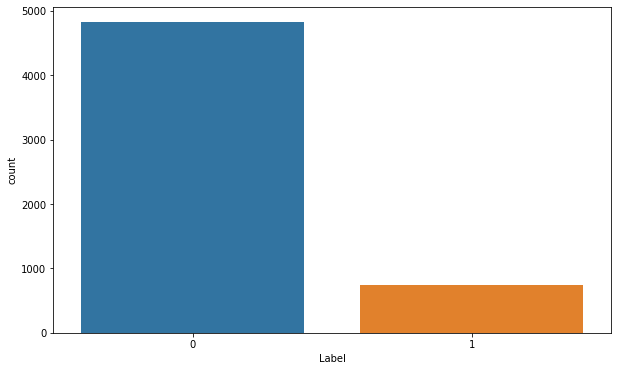

In [10]:
plt.figure(figsize = (10,6))
sns.countplot(Y)

### Data Splitting
Since we are using a univariate dataset, we can directly split our data into training and testing subsets. The first subset is utilized to fit/train the model. The second subset is used for prediction. The main motive is to estimate the performance of the model on new data.

In [11]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=24)

## Model

In deep learning, a convolutional neural network (CNN, or ConvNet) is a class of artificial neural network, most commonly applied to analyze visual imagery. They take advantage of the hierarchical pattern in data and assemble patterns of increasing complexity using smaller and simpler patterns embossed in their filters. Therefore, on a scale of connectivity and complexity, CNNs are on the lower extreme.

Conv1D means each channel in the input and filter is 1 dimensional.

Refer Conv1D [API](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D)

In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
max_length = max([len(s.split()) for s in X])
vocab_size = len(tokenizer.word_index)+1

In [13]:
x_train_tokens = tokenizer.texts_to_sequences(x_train)
x_test_tokens = tokenizer.texts_to_sequences(x_test)
x_train_pad = pad_sequences(x_train_tokens, padding='post', maxlen=max_length)
x_test_pad = pad_sequences(x_test_tokens, padding='post', maxlen=max_length)

In [14]:
tf.random.set_seed(24)
textcnnmodel = Sequential()
textcnnmodel.add(Embedding(vocab_size,256, input_length=max_length))
textcnnmodel.add(Conv1D(128,3,activation='relu'))
textcnnmodel.add(MaxPool1D(pool_size=4,strides=3))
textcnnmodel.add(GlobalAveragePooling1D())
textcnnmodel.add(Flatten())
textcnnmodel.add(Dense(64, activation='relu'))
textcnnmodel.add(Dense(32, activation='relu'))
textcnnmodel.add(Dense(16, activation='relu'))
textcnnmodel.add(Dense(1 if len(Y.unique())<=2 else len(Y.unique()), activation='sigmoid' if len(Y.unique())<=2 else 'softmax'))
if len(Y.unique())==2:
  textcnnmodel.compile(optimizer='adam',loss=tf.losses.BinaryCrossentropy(),metrics=['accuracy'])
else: 
  textcnnmodel.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
textcnnmodel.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 75, 256)           1706240   
_________________________________________________________________
conv1d (Conv1D)              (None, 73, 128)           98432     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 24, 128)           0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2

In [15]:
earlystopping=callbacks.EarlyStopping(monitor='val_loss',mode='min',patience=3,restore_best_weights=True)
textcnnmodel.fit(x_train_pad, y_train,epochs=15,validation_data=(x_test_pad, y_test),callbacks=[earlystopping])

Epoch 1/15
140/140 [==============================] - 34s 12ms/step - loss: 0.2778 - accuracy: 0.8948 - val_loss: 0.1141 - val_accuracy: 0.9641
Epoch 2/15
140/140 [==============================] - 1s 10ms/step - loss: 0.0608 - accuracy: 0.9829 - val_loss: 0.0609 - val_accuracy: 0.9812
Epoch 3/15
140/140 [==============================] - 1s 10ms/step - loss: 0.0312 - accuracy: 0.9910 - val_loss: 0.0536 - val_accuracy: 0.9839
Epoch 4/15
140/140 [==============================] - 1s 10ms/step - loss: 0.0138 - accuracy: 0.9964 - val_loss: 0.1082 - val_accuracy: 0.9668
Epoch 5/15
140/140 [==============================] - 1s 10ms/step - loss: 0.0089 - accuracy: 0.9980 - val_loss: 0.0637 - val_accuracy: 0.9883
Epoch 6/15
140/140 [==============================] - 1s 10ms/step - loss: 0.0069 - accuracy: 0.9987 - val_loss: 0.0642 - val_accuracy: 0.9857


#### Model Evalution




In [16]:
loss, accuracy = textcnnmodel.evaluate(x_train_pad, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = textcnnmodel.evaluate(x_test_pad, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy)) 

Training Accuracy: 0.9962
Testing Accuracy:  0.9839


#### Confusion Matrix
A confusion matrix is utilized to understand the performance of the classification model or algorithm in machine learning for a given test set where results are known.

In [17]:
if len(Y.unique())==2:
  y_pred=np.round(textcnnmodel.predict(x_test_pad))
else: 
  y_pred=np.argmax(textcnnmodel.predict(x_test_pad),axis=1) 
y_pred[:10]

array([[0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.]], dtype=float32)

Text(0.5, 15.0, 'Predicted label')

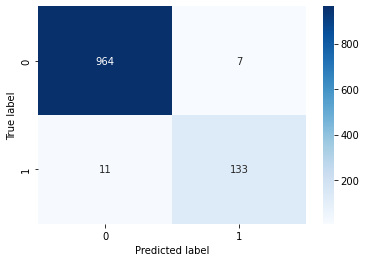

In [18]:
conf_mat=confusion_matrix(y_test,y_pred)
sns.heatmap(conf_mat,annot=True,cmap='Blues',fmt='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')

#### Classification Report
A Classification report is used to measure the quality of predictions from a classification algorithm. How many predictions are True, how many are False.
* Where:
  - Precision:- Accuracy of positive predictions.
  -  Recall:- Fraction of positives that were correctly identified.
  -  F1-score:- Percent of positive predictions were correct
  -  Support:- Support is the number of actual occurrences of the class in the specified dataset.

In [19]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       971
           1       0.95      0.92      0.94       144

    accuracy                           0.98      1115
   macro avg       0.97      0.96      0.96      1115
weighted avg       0.98      0.98      0.98      1115



####**Creator: Aishwarya Guntoju , Github: [Profile](https://github.com/DSAishwaryaG)**